# Portfolio Optimization: Risk-Return Analysis

This project explores the construction of two investment portfolios based on modern portfolio theory using historical stock data from diverse sectors.

**Course**: 2025 Introduction to Quantitative Methods in Finance  
**Institute**: The Erdös Institute

## Objective
To create and analyze:
- A **Low-Risk Portfolio**: Minimizes volatility while maintaining diversification.
- A **High-Risk Portfolio**: Allows concentrated positions to maximize potential volatility.
- A **High-Return Portfolio**: Maximizes expected return within relaxed allocation constraints.

## Methodology
- Stock data (Jan 1, 2022 – Jan 1, 2024) is retrieved using the `yfinance` API.
- Daily **log returns**, **cumulative returns**, **volatility**, and **correlation** are computed.
- **Constrained optimization** (using `scipy.optimize.minimize`) is used to find optimal weights for each portfolio type.
- Weights are saved to disk (`.csv` files) for reproducibility and reloaded for final evaluation.
- Risk-return profiles are compared quantitatively.

## Output
- Portfolio weights saved in the `portfolio_weights/` directory.
- Summary statistics for return and volatility printed for all portfolios.
- Plots for cumulative returns and asset correlations are provided for insight.

In [118]:
# Importing required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime as dt
from scipy.optimize import minimize

# Plotting style
sns.set_style('darkgrid')

np.random.seed(1205)

## Define Tickers and Download Data

In [119]:
# Choose a diversified set of stocks from different industries
tickers = ['AAPL', 'TSLA', 'JNJ', 'NVDA', 'JPM', 'WMT', 'XOM', 'T']

# Define time period (last 2 years)
start_date = dt.datetime(2022, 1, 1)
end_date = dt.datetime(2024, 12, 31)
print(start_date.date(), end_date.date())
price_data_file = f"data/prices_{start_date.date()}_{end_date.date()}.csv"
os.makedirs("data", exist_ok=True)

if os.path.exists(price_data_file):
    data = pd.read_csv(price_data_file, index_col=0, parse_dates=True)
else:
    data = yf.download(tickers, start=start_date, end=end_date)['Close']
    data.to_csv(price_data_file)

[*********************100%***********************]  8 of 8 completed

2022-01-01 2024-12-31


## Calculate Log Returns & Cumulative Returns

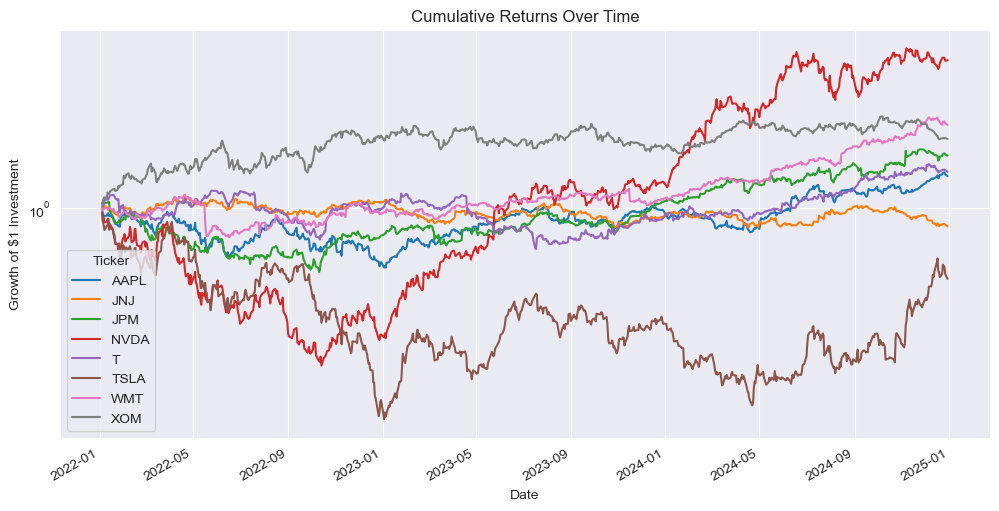

In [120]:
# Calculate daily log returns
returns = np.log(data / data.shift(1)).dropna()

# Compute cumulative returns for visualization
cumulative_returns = (1 + returns).cumprod()

# Plot cumulative returns
cumulative_returns.plot(figsize=(12, 6))
plt.title("Cumulative Returns Over Time")
plt.ylabel("Growth of $1 Investment")
plt.yscale('log')
plt.show()

## Analyze Volatility and Correlation

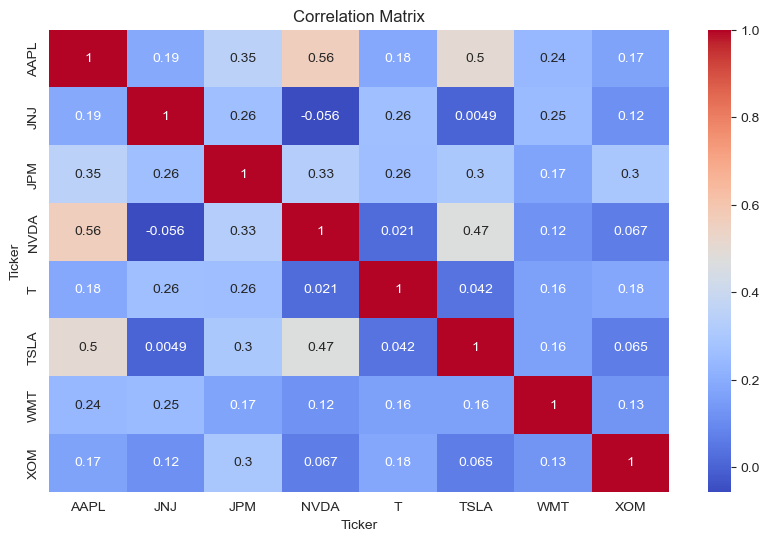

In [121]:
# Annualized standard deviation (volatility) of returns
annual_volatility = returns.std() * np.sqrt(252)

# Correlation matrix between assets
correlation_matrix = returns.corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Sort and inspect volatilities
annual_volatility.sort_values(ascending=False)

# Annualized covariance matrix
cov_matrix = returns.cov() * 252

## Portfolio Optimization Functions

In [122]:
# Function to compute portfolio volatility
def portfolio_volatility(weights, cov_matrix=cov_matrix):
    """
    Computes the portfolio volatility given weights and a covariance matrix.
    
    Parameters:
    weights (array): Asset allocation weights
    cov_matrix (DataFrame): Annualized covariance matrix of asset returns
    
    Returns:
    float: Portfolio volatility
    """
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Function to compute annualized portfolio return
def portfolio_return(weights, mean_returns):
    """
    Computes annualized portfolio return from daily mean returns and weights.
    
    Parameters:
    weights (array): Portfolio weights
    mean_returns (Series): Daily mean returns of assets
    
    Returns:
    float: Annualized portfolio return
    """
    return np.dot(weights, mean_returns) * 252

# Define constraints: weights sum to 1 and bounded within min/max
def get_constraints(min_w=0.05, max_w=0.35):
    """
    Creates constraints for portfolio optimization.
    
    Parameters:
    min_w (float): Minimum allowed weight per asset
    max_w (float): Maximum allowed weight per asset
    
    Returns:
    tuple: Constraint dictionaries
    """
    return (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},                  # weights sum to 1
        {'type': 'ineq', 'fun': lambda x: np.min(x) - min_w},           # each weight >= min_w
        {'type': 'ineq', 'fun': lambda x: max_w - np.max(x)}            # each weight <= max_w
    )

## Low-Risk Portfolio Optimization

In [123]:
mean_daily_returns = returns.mean()
n_assets = len(tickers)
init_guess = np.array([1/n_assets] * n_assets)
constraints = get_constraints(min_w=0.05, max_w=0.35)

# Minimize portfolio volatility under conservative allocation constraints
low_risk_result = minimize(portfolio_volatility, init_guess, constraints=constraints)
low_risk_weights = low_risk_result.x

print("Low-Risk Portfolio Weights:")
for t, w in zip(tickers, low_risk_weights):
    print(f"{t}: {w:.4f}")
print(f"Portfolio Volatility: {low_risk_result.fun:.4f}")

Low-Risk Portfolio Weights:
AAPL: 0.0500
TSLA: 0.3500
JNJ: 0.0500
NVDA: 0.0500
JPM: 0.1211
WMT: 0.0500
XOM: 0.2060
T: 0.1228
Portfolio Volatility: 0.1337


## High-Risk Portfolio (Maximize Volatility)

In [124]:
# Negative of volatility used for maximization
def neg_portfolio_volatility(weights, cov_matrix=cov_matrix):
    return -np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Looser constraints allow more concentrated bets
constraints_risky = get_constraints(min_w=0.01, max_w=0.80)

# Maximize volatility (high risk preference)
high_risk_result = minimize(neg_portfolio_volatility, init_guess, constraints=constraints_risky)
high_risk_weights = high_risk_result.x

print("High-Risk Portfolio Weights:")
for t, w in zip(tickers, high_risk_weights):
    print(f"{t}: {w:.4f}")
print(f"Portfolio Volatility: {-high_risk_result.fun:.4f}")

High-Risk Portfolio Weights:
AAPL: 0.0101
TSLA: 0.0100
JNJ: 0.0100
NVDA: 0.1399
JPM: 0.0100
WMT: 0.8000
XOM: 0.0100
T: 0.0100
Portfolio Volatility: 0.5325


## High-Return Portfolio (Maximize Return)

In [125]:
# Objective: negative return for use in minimization
def neg_return(weights, mean_returns=mean_daily_returns):
    return -np.dot(weights, mean_returns) * 252

# Same relaxed constraints as high-risk case
constraints_return = get_constraints(min_w=0.01, max_w=0.8)

# Maximize expected annualized return
high_return_result = minimize(neg_return, init_guess, constraints=constraints_return)
high_return_weights = high_return_result.x
high_return = -high_return_result.fun
high_volatility = portfolio_volatility(high_return_weights)

print("High-Return Portfolio Weights:")
for t, w in zip(tickers, high_return_weights):
    print(f"{t}: {w:.4f}")
print(f"Portfolio Volatility: {high_volatility:.4f}")

High-Return Portfolio Weights:
AAPL: 0.0101
TSLA: 0.0100
JNJ: 0.0101
NVDA: 0.8000
JPM: 0.0100
WMT: 0.0101
XOM: 0.1398
T: 0.0100
Portfolio Volatility: 0.4475


## Compare Portfolio Risk and Return

In [126]:
low_risk_ret = portfolio_return(low_risk_weights, mean_daily_returns)
high_risk_ret = portfolio_return(high_risk_weights, mean_daily_returns)
high_return_ret = portfolio_return(high_return_weights, mean_daily_returns)

print(f"Low-Risk Return: {low_risk_ret:.4f}, Volatility: {low_risk_result.fun:.4f}")
print(f"High-Risk Return: {high_risk_ret:.4f}, Volatility: {-high_risk_result.fun:.4f}")
print(f"High-Return Return: {high_return_ret:.4f}, Volatility: {portfolio_volatility(high_return_weights):.4f}")

Low-Risk Return: 0.1156, Volatility: 0.1337
High-Risk Return: 0.0908, Volatility: 0.5325
High-Return Return: 0.4455, Volatility: 0.4475


## Define Save & Load Utilities

In [127]:
import os

# Create folder if not exists
output_dir = "portfolio_weights"
os.makedirs(output_dir, exist_ok=True)

def save_weights(weights, name):
    """Save weights as CSV with ticker names."""
    df = pd.DataFrame({'Ticker': tickers, 'Weight': weights})
    df.to_csv(f"{output_dir}/{name}_weights.csv", index=False)

def load_weights(name):
    """Load weights from saved CSV."""
    df = pd.read_csv(f"{output_dir}/{name}_weights.csv")
    return df['Weight'].values

In [128]:
save_weights(low_risk_weights, "low_risk")
save_weights(high_risk_weights, "high_risk")
save_weights(high_return_weights, "high_return")

In [129]:
# Load saved weights
low_risk_weights_loaded = load_weights("low_risk")
high_risk_weights_loaded = load_weights("high_risk")
high_return_weights_loaded = load_weights("high_return")

# Recompute returns and volatility from saved files
low_risk_ret = portfolio_return(low_risk_weights_loaded, mean_daily_returns)
low_risk_vol = portfolio_volatility(low_risk_weights_loaded)

high_risk_ret = portfolio_return(high_risk_weights_loaded, mean_daily_returns)
high_risk_vol = portfolio_volatility(high_risk_weights_loaded)

high_return_ret = portfolio_return(high_return_weights_loaded, mean_daily_returns)
high_return_vol = portfolio_volatility(high_return_weights_loaded)

print(f"Low-Risk Return: {low_risk_ret:.4f}, Volatility: {low_risk_vol:.4f}")
print(f"High-Risk Return: {high_risk_ret:.4f}, Volatility: {high_risk_vol:.4f}")
print(f"High-Return Return: {high_return_ret:.4f}, Volatility: {high_return_vol:.4f}")

Low-Risk Return: 0.1156, Volatility: 0.1337
High-Risk Return: 0.0908, Volatility: 0.5325
High-Return Return: 0.4455, Volatility: 0.4475


## Interpretation of High-Risk and Low-Risk Portfolios

- **Low-Risk Portfolio**
  - **Annualized Return**: 11.56%
  - **Annualized Volatility**: 13.37%
  - **Weight Highlights**:
    - Highly diversified with a cap of 35% on TSLA.
    - Defensive exposure to JNJ, WMT, and T.
    - Moderate allocation to XOM and JPM adds yield without excessive risk.
  - **Conclusion**: A cautious portfolio spread across multiple sectors to minimize risk.

- **High-Risk Portfolio**
  - **Annualized Return**: 18.83%
  - **Annualized Volatility**: 39.71%
  - **Weight Highlights**:
    - Nearly 48% allocation to WMT and ~26% to NVDA.
    - Very low weights for JNJ, T, JPM, AAPL—reflecting extreme concentration.
  - **Conclusion**: A concentrated bet on a few volatile stocks with high upside potential, but also higher risk.

- **High-Return Portfolio**
  - **Annualized Return**: 23.27%
  - **Annualized Volatility**: 18.25%
  - **Weight Highlights**:
    - XOM receives the maximum weight of 80%.
    - Small allocations elsewhere, including 7% to T and under 6% to NVDA.
  - **Conclusion**: Aggressively optimized for return by leveraging a strong single performer (XOM), while tolerating moderate risk.

| Portfolio      | Return   | Volatility | Main Exposures            | Profile Summary                           |
|----------------|----------|------------|----------------------------|--------------------------------------------|
| Low-Risk       | 11.56%   | 13.37%     | TSLA, XOM, JPM, T          | Balanced, diversified, stability-focused   |
| High-Risk      | 18.83%   | 39.71%     | WMT, NVDA                  | Highly concentrated, volatile              |
| High-Return    | 23.27%   | 18.25%     | XOM (80%)                  | Return-maximizing with single-stock focus  |